In [9]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
    hide_toggle()

In [1]:
import numpy
import pandas
import os
import matplotlib.pyplot as plot
import seaborn as sns
from shutil import copyfile
from IPython.display import IFrame, display, HTML
#tqdm_pandas is needed only for old versions of tqdm
from tqdm import tqdm_pandas
from tqdm.autonotebook  import tqdm
%matplotlib inline

# This is supposed to enhance default pandas display
pandas.set_option('display.width',200)
pandas.set_option('display.max_colwidth',200)

# the folder where this experiment will be stored
EXPERIMENT = 'universal_sentence_similarity_lite'

# The name of the docker image (used to display docker command to copy apply files to windows host)
DOCKER_IMAGE_NAME = 'dev_ds_1'

# Some common resources
PANDAS_STORE = '../PandasStore'
KAGGLE_EXE = '/root/anaconda3/bin/kaggle'
PICKLE_EXTENSION = '.pkl'
CLEAN_TRAINING_DATA = 'clean_training'
CLEAN_CHALLENGE_DATA = 'clean_challenge'

# Other useful constants
ZIP_EXTENSION = '.zip'
SEP_IN_FILE_NAME = '!'
KAGGLE_GET_SUBMISSIONS_COMMAND = KAGGLE_EXE +' competitions submissions quora-question-pairs --csv'
EXCEL_PRECISION='%.6f'

# Try to have a minimal decoration in notebook output
def print_html(s):
    display(HTML(s, metadata=dict(isolated=True)))
    
def start_small():
    display(HTML('<span><small>', metadata=dict(isolated=True)))

def print_small(s):
    print_html('<small>',s,'</small>')

def end_small():
    display(HTML('</small></span>', metadata=dict(isolated=True)))

def start_italic():
    display(HTML('<i>', metadata=dict(isolated=True)))

def print_italic(s):
    print_html('<i>'+s+'</i>')

def end_italic():
    display(HTML('</i>', metadata=dict(isolated=True)))

def start_bold():
    display(HTML('<b>', metadata=dict(isolated=True)))

def print_bold(s):
    print_html('<b>'+s+'</b>')

def end_bold():
    display(HTML('</b>', metadata=dict(isolated=True)))

def print_bullet(s):
    print_html('<li>'+s)

def print_section(s):
    print_bold(s)
    print_html('<HR>')

def print_done(s):
    print_html('<span style="color:LIMEGREEN"><small><b><i>'+s+'</i></b><p></p></small></span>')

def print_info(s):
    print_html('<span style="color:LIMEGREEN"><small>'+s+'</small></span>')
    
def print_warning(s):
    print_html('<span style="color:LIGHTSALMON"><small>'+s+'</small></span>')

## Plenty of small tools to help not creating a huge mess

def global_pandas_store_file_name(file_name,ext='.pkl'):
    return PANDAS_STORE +'/'+file_name+ext

def local_pandas_store_file_name(file_name):
    return env_file_name(file_name,PICKLE_EXTENSION)

def env_path():
    return '../'+EXPERIMENT

def env_file_name(file_name,ext=''):
    return env_path()+'/'+file_name+ext

def absolute_env_file_name(file_name,ext=''):
    return str(os.path.abspath(env_path()+'/'+file_name+ext))

def copy_from_pandas_store_if_missing(file_name):
    if not os.path.exists(env_file_name(file_name)):
        print_info('Make local copy of %s' % global_pandas_store_file_name(file_name))
        copyfile(global_pandas_store_file_name(file_name),local_pandas_store_file_name(file_name))

def prepare_environnement():
    print_section('Prepare %s environment' % EXPERIMENT)
    # with recent versions use tqdm.pandas(desc="my bar!")
    # tqdm_pandas(tqdm())
    tqdm.pandas()
    if not os.path.exists(env_path()):
        os.mkdir(env_path())
    copy_from_pandas_store_if_missing(CLEAN_TRAINING_DATA)
    copy_from_pandas_store_if_missing(CLEAN_CHALLENGE_DATA)
    print_done('Done')
    print

## Tools to cache important and costly data

def load_dataframe(file_name):
    df = pandas.read_pickle(local_pandas_store_file_name(file_name))
    return df

def save_dataframe(df,file_name):
    print_info('Save %s' % file_name )
    df.to_pickle(local_pandas_store_file_name(file_name))

def load_or_build_dataframe(dataframe_name,file_name,builder,dataframe):
    print_section('%s: Load or rebuild %s' % (dataframe_name,file_name))
    if os.path.exists(local_pandas_store_file_name(file_name)):
        print_info("!!!!! %s is cached!!!" % local_pandas_store_file_name(file_name))
        df = load_dataframe(file_name)
    else:
        print_warning("!!!!! %s does not exists!!!" % local_pandas_store_file_name(file_name))
        print_warning('Rebuild and save it')
        df = builder(dataframe)
        save_dataframe(df,file_name)
    print_done('Done:%s contains %d lines' % (file_name,len(df)))
    return df

# Code to generate all combination of numeric features
from itertools import compress, product
from itertools import chain, combinations

def all_numeric_columns(dataframe):
    l = list()
    for name in dataframe.columns:
        if dataframe.dtypes[name] in ['int64','float64'] and name not in ['test_id','id','qid1','qid2','is_duplicate']:
            l.append( name)
    return l

def all_float_columns(dataframe):
    l = list()
    for name in dataframe.columns:
        if dataframe.dtypes[name] in ['float64']:
            l.append( name)
    return l

def all_subsets(ss):
    return list(chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1))))

def clean_combination_name(c):
    return str(numpy.asarray(c)).replace("' '","+").replace("['","").replace("']","").replace("'","").replace(" ","").replace('\n','+')

def clean_all_combination_names(dataframe):
    for c in all_subsets(all_numeric_columns(dataframe)):
        if len(c)>0:
            print('|%s|'% clean_combination_name(c))

#print( 'All numeric columns\n%s' % all_numeric_columns(train_dataframe))
#print('All combinations of numeric columns\n %d combinations\n' % len(all_subsets(all_numeric_columns(train_dataframe))))
#for c in all_subsets(all_numeric_columns(train_dataframe)):
#    print(c)
#clean_all_combination_names(train_dataframe)
#print( '%d combination of features will be studied' % (len(list(all_subsets(all_numeric_columns(train_dataframe))))-1))

# code to put plots in a grid

def multiplot_from_generator(g, num_columns, figsize_for_one_row=None):
    # call 'next(g)' to get past the first 'yield'
    next(g)
    # default to 15-inch rows, with square subplots
    if figsize_for_one_row is None:
        figsize_for_one_row = (15, 15/num_columns)
    try:
        while True:
            # call plt.figure once per row
            plot.figure(figsize=figsize_for_one_row)
            for col in range(num_columns):
                ax = plot.subplot(1, num_columns, col+1)
                next(g)
    except StopIteration:
        pass

# apply tools
def apply_file_name(criteria,kind,model_key,ext='.csv'):
    return env_file_name(SEP_IN_FILE_NAME.join((EXPERIMENT,criteria,kind,clean_combination_name(model_key).replace('/','_div_'))),ext=ext)

def apply_absolute_file_name(criteria,kind,model_key,ext='.csv'):
    return str(os.path.abspath(apply_file_name(criteria,kind,model_key,ext=ext)))

# Zip tools
from zipfile import ZipFile,ZIP_DEFLATED 
import zlib
import os
from pathlib import Path

def zip_file_name(original_file_name):
    return str(Path(original_file_name).with_suffix('.zip'))

def zip_file_and_delete(original_file_name):
    zip_name = zip_file_name(original_file_name) 
    zip = ZipFile(str(zip_name), 'w',compression=ZIP_DEFLATED)
    zip.write(original_file_name)
    zip.close()
    os.unlink(original_file_name)
    return zip_name

# Excel tools
def excel_file_name(file_name):
    return env_file_name(file_name,ext='.xlsx')

def pandas_to_excel(dataframe,file_name):
    dataframe.to_excel(excel_file_name(SEP_IN_FILE_NAME.join([EXPERIMENT,file_name])),float_format=EXCEL_PRECISION)

def save_models_dict_to_excel(models_dict,file_name='all_models'):
    results = models_dict_to_models_results(models_dict)
    results.to_excel(excel_file_name('_'.join([EXPERIMENT,file_name])),float_format="%.4f")

# Kaggle submissions tool
import subprocess

def load_kaggle_submissions():
    print_section('Load all Kaggle submissions')
    generic_submissions_name = EXPERIMENT+'_submissions'
    file_name_csv = absolute_env_file_name(generic_submissions_name,ext='.csv')
    file_name_excel = absolute_env_file_name(excel_file_name(generic_submissions_name))
    csv_output = open(file_name_csv,"w")
    proc = subprocess.Popen(KAGGLE_GET_SUBMISSIONS_COMMAND.split(),stdout=csv_output)
    proc.wait()
    csv_output.close()
    print_info('All submissions are available in .csv&nbsp;&nbsp;format with %s' % file_name_csv)
    submissions = pandas.read_csv(file_name_csv,error_bad_lines=True,warn_bad_lines=True)
    # fix dataframe so it is more convenient to use
    #submissions = submissions[submissions['status']=='complete' & submissions['description']!='first xgboost']
    submissions = submissions[submissions['status']=='complete']
    submissions = submissions[['date','publicScore','privateScore','description','fileName']]
    submissions['date'] = pandas.to_datetime(submissions['date'])
    submissions['publicScore'] = submissions['publicScore'].astype('float64')
    submissions['privateScore'] = submissions['privateScore'].astype('float64')
    submissions.to_excel(file_name_excel,float_format="%.4f")
    print_info('All submissions are available in .xlsx format with %s' % file_name_excel)
    return submissions

def show_last_submissions(submissions,n=3):
    return submissions.nlargest(n,'date')

def put_first(l,e):
    l.insert(0,e)
    return list(dict.fromkeys(l))


def show_best_submissions(submissions,n=3,metric='publicScore',):
    return submissions.nsmallest(n,metric)[put_first(submissions.columns.values.tolist(),metric)]

In [2]:
# @hidden
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 } else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [6]:
prepare_environnement()
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)

In [7]:
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
import sentencepiece as spm
import numpy as np
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
module = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-lite/2")
input_placeholder = tf.sparse_placeholder(tf.int64, shape=[None, None])
encodings = module(
    inputs=dict(
        values=input_placeholder.values,
        indices=input_placeholder.indices,
        dense_shape=input_placeholder.dense_shape))

with tf.Session() as sess:
    spm_path = sess.run(module(signature="spm_path"))

sp = spm.SentencePieceProcessor()
sp.Load(spm_path)
print("SentencePiece model loaded at {}.".format(spm_path))


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
SentencePiece model loaded at b'/tmp/tfhub_modules/539544f0a997d91c327c23285ea00c37588d92cc/assets/universal_encoder_8k_spm.model'.


In [17]:
def process_to_IDs_in_sparse_format(sp, sentences):
  # An utility method that processes sentences with the sentence piece processor
  # 'sp' and returns the results in tf.SparseTensor-similar format:
  # (values, indices, dense_shape)
  ids = [sp.EncodeAsIds(x) for x in sentences]
  max_len = max(len(x) for x in ids)
  dense_shape=(len(ids), max_len)
  values=[item for sublist in ids for item in sublist]
  indices=[[row,col] for row in range(len(ids)) for col in range(len(ids[row]))]
  return (values, indices, dense_shape)


def compute_distance(sp, session,q1, q2):
  ids = [sp.EncodeAsIds(q1),sp.EncodeAsIds(q2)]
  max_len = max(len(x) for x in ids)
  dense_shape=(len(ids), max_len)
  values=[item for sublist in ids for item in sublist]
  indices=[[row,col] for row in range(len(ids)) for col in range(len(ids[row]))]
  v = session.run(
      encodings,
      feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})
  try:
      return distance.euclidean(v[0],v[1])
  except:
      return 1000000.0


def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

from scipy.spatial import distance
def build_all_similarities(dataframe):
    add_column_from_columns(dataframe,'universal_sentence_similarity',lambda r: compute_distance(sp,session,r.question1,r.question2))

In [24]:
session = tf.Session()
session.run([tf.global_variables_initializer(), tf.tables_initializer()])
train_dataframe=load_or_build_dataframe('Training universal sentence similarity','training_universal_sentence_similarity',build_all_similarities,train_dataframe)
challenge_dataframe=load_or_build_dataframe('Challenge universal sentence similarity','challenge_universal_sentence_similarity',build_all_similarities,challenge_dataframe)
session.close()

In [29]:
train_dataframe.head()

,id,qid1,qid2,question1,question2,is_duplicate,universal_sentence_similarity
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,0.464587
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,0.969583
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,0.620010
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,1.243714
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,0.891251


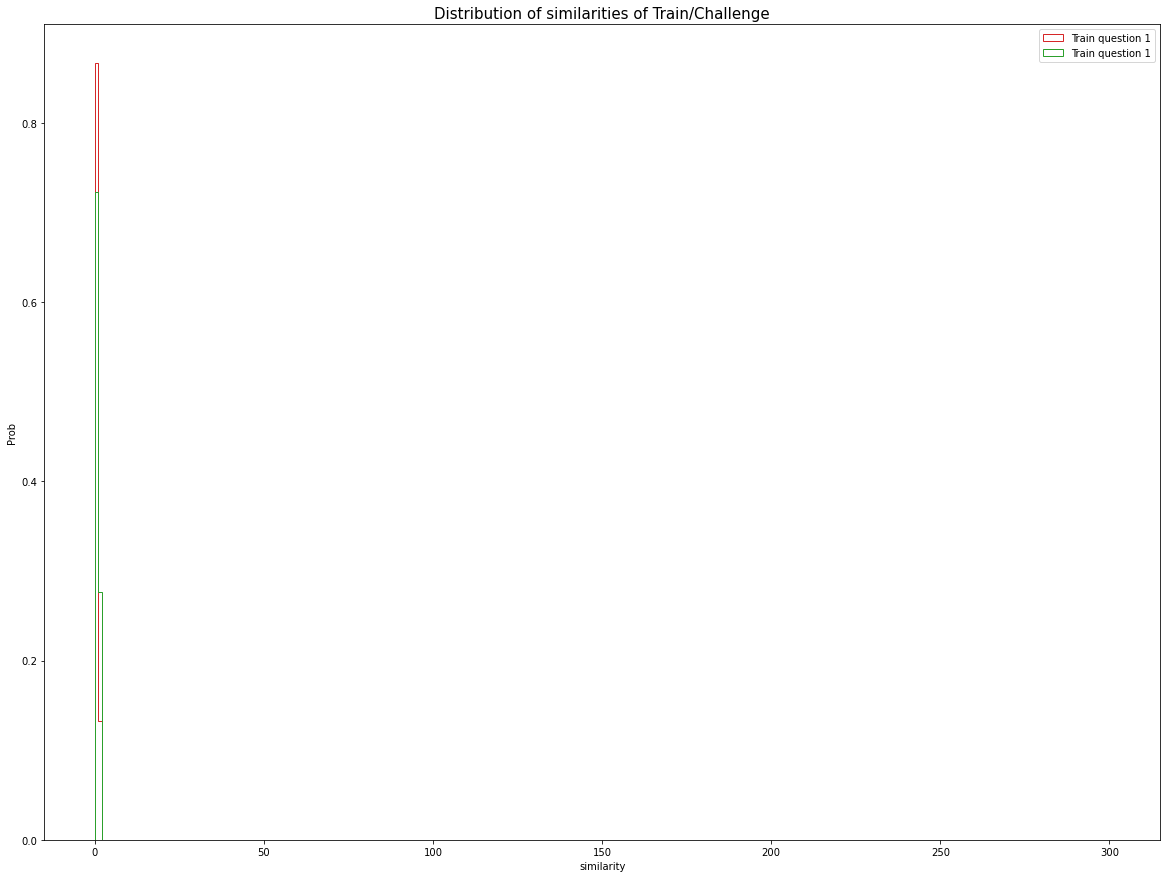

In [35]:
import seaborn as sns
palette = sns.color_palette()
plot.figure(figsize=(20, 15))
plot.hist(train_dataframe['universal_sentence_similarity'],bins=300,range=[0,300],density=True,color=palette[3],label='Train question 1',histtype='step')
plot.hist(challenge_dataframe['universal_sentence_similarity'],bins=300,range=[0,300],density=True,color=palette[2],label='Train question 1',histtype='step')
plot.title('Distribution of similarities of Train/Challenge', fontsize=15)
plot.xlabel('similarity')
plot.ylabel('Prob')
plot.legend()

In [37]:

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# This will add a suffix to all keys of a dict
# Used to add _test,_train,_full to keys of infos about a model

FAKE_INFOS_ON_MODEL_TEST_TRAIN = {
    'accuracy_train': 0,
    'score_train': 0,
    'logloss_proba_train': 0,
    'model_train': None,
    'accuracy_test': 0,
    'score_test': 0,
    'logloss_proba_test': 0,
    'model_test': None
}

FAKE_INFOS_ON_MODEL_FULL = {
    'accuracy_full': 0,
    'score_full': 0,
    'logloss_proba_full': 0,
    'model_full': None
}


PRINT_INFOS_ON_2_MODELS = {
    'accuracy_test': '%.4f',
    'score_test': '%.4f',
    'logloss_proba_test': '%.4f',

    'accuracy_train': '%.4f',
    'score_train': '%.4f',
    'logloss_proba_train': '%.4f',

    'accuracy_full': '%.4f',
    'score_full': '%.4f',
    'logloss_proba_full': '%.4f',

    'nb_features': '%d',
    'column_names': '%s'
}

PRINT_INFOS_ON_MODEL_TRAIN = {
    'accuracy_train': '%.4f',
    'score_train': '%.4f',
    'logloss_proba_train': '%.4f',
}

PRINT_INFOS_ON_MODEL_TEST = {
    'accuracy_test': '%.4f',
    'score_test': '%.4f',
    'logloss_proba_test': '%.4f',
}

PRINT_INFOS_ON_MODEL_FULL = {
    'accuracy_full': '%.4f',
    'score_full': '%.4f',
    'logloss_proba_full': '%.4f'
}

def add_suffix_to_keys(d,s):
    return dict(zip([k+s for k in d.keys()],d.values()))

def format_model_infos(message,keys_formats,infos):
    values = list()
    for k,f in keys_formats.items():
        values.append( f % infos[k])
    #return print_info( '%s %s' %(message,'&nbsp;|&nbsp;'.join(values)))
    return '%s %s' %(message,' | '.join(values))

def print_model_infos(message,keys_formats,infos):
    print_info(format_model_infos(message,keys_formats,infos))
def print_header_infos_model(key_formats):
    print_info('|'.join(key_formats.keys()))


def compute_metrics_model(model,input_df,target_df,suffix,show=True):
    prediction_df = model.predict(input_df)
    prediction_proba_df = model.predict_proba(input_df)
    res = metrics.classification_report(target_df,prediction_df,output_dict=True)
    accuracy = res['accuracy']
    score = res['0']['f1-score']*(1-0.17)+res['1']['f1-score']*.17
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df)
    if show:
        print('Classification report on %s' % suffix)
        print(metrics.classification_report(target_df,prediction_df))
    return add_suffix_to_keys(
            {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           },
           suffix)


def build_naivebayes_model_with_test(input,column_names,target,show=True):
    # print_bullet('Multinomial Naive Bayes with test on %s' % clean_combination_name(column_names))
    input_train = pandas.DataFrame()
    for column_name in column_names:
        input_train[column_name]=input[column_name]
    target_train = target
    input_train,input_test,target_train,target_test = train_test_split(input_train,target_train,random_state=42,test_size=0.2)
    if show:
        print_info( 'Training on %d Test %d x %d' % (len(input_train),len(input_test),len(input_train.columns)))
    model = MultinomialNB()
    #naive_bayes_classifier_with_test=ComplementNB()
    model.fit(input_train,target_train)
    infos = compute_metrics_model(model,input_test,target_test,'_test',show=show)
    infos.update(compute_metrics_model(model,input_train,target_train,'_train',show=show))
    if show:      
        print_model_infos('Test ',PRINT_INFOS_ON_MODEL_TEST,infos)
        print_model_infos('Train ',PRINT_INFOS_ON_MODEL_TRAIN,infos)
    return  infos
    
def build_naivebayes_model_full(input,column_names,target,show=True):
    input_full = pandas.DataFrame()
    for column_name in column_names:
        input_full[column_name] = input[column_name]
    if show:
        print_info( 'Training on %dx%d' % (len(input_full),len(input_full.columns)))
    target_full = target
    model = MultinomialNB()
    model.fit(input_full,target_full)
    infos = compute_metrics_model(model,input_full,target_full,'_full',show=show)
    if show:
        print_model_infos('Full ',PRINT_INFOS_ON_MODEL_FULL,infos)
    return infos

def FAKE_build_naivebayes_model_full(input,column_names,target,show=True):
    return FAKE_INFOS_ON_MODEL_FULL

def FAKE_build_naivebayes_model_with_test(input,column_names,target,show=True):
    return FAKE_INFOS_ON_MODEL_TEST_TRAIN

def build_model(train_dataframe,column_names,target,show=True):
    infos = build_naivebayes_model_with_test(train_dataframe,column_names,target,show=show)
    infos.update(build_naivebayes_model_full(train_dataframe,column_names,target,show=show))
    infos.update(
        {
            'nb_features':len(column_names),
            'column_names':clean_combination_name(column_names),
            'columns': column_names
        })
    return infos

def FAKE_build_model(train_dataframe,column_names,target,show=True):
    infos = FAKE_build_naivebayes_model_with_test(train_dataframe,column_names,target,show=show)
    infos.update(FAKE_build_naivebayes_model_full(train_dataframe,column_names,target,show=show))
    infos.update(
        {
            'nb_features':len(column_names),
            'column_names':clean_combination_name(column_names),
            'columns': column_names
        })
    return infos

In [38]:
model_result = build_model(train_dataframe,['universal_sentence_similarity'],train_dataframe['is_duplicate'])

Classification report on _test
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     50803
           1       0.00      0.00      0.00     30055

    accuracy                           0.63     80858
   macro avg       0.31      0.50      0.39     80858
weighted avg       0.39      0.63      0.48     80858

Classification report on _train
              precision    recall  f1-score   support

           0       0.63      1.00      0.77    204224
           1       0.00      0.00      0.00    119208

    accuracy                           0.63    323432
   macro avg       0.32      0.50      0.39    323432
weighted avg       0.40      0.63      0.49    323432



Classification report on _full
              precision    recall  f1-score   support

           0       0.63      1.00      0.77    255027
           1       0.00      0.00      0.00    149263

    accuracy                           0.63    404290
   macro avg       0.32      0.50      0.39    404290
weighted avg       0.40      0.63      0.49    404290

